<left>
    <img src="https://kpi.ua/files/images/kpi.png" width="300" alt="kpi logo"  />
</left>


# Modeling water pipes faults in KPI Campus

Course work on Mathematical Modelling course

Author: Dmytro Bubela

Group: KM-82


# Preparation

To recreate KPI campus water supply system (KCWSS) it was decided to scrap fault alerts messanges from Student Campus channel in telegram ("Студгородок КПИ" https://t.me/kpicampus) and to represent the all structure as a directed graph.

The chat history was exported and analysed to separate groups of dormitories with problems with the water supply at the same time.

> Not all water problems may have been analysed because of automatic message picking and also not all problems have been described on the channel.

The result set of dormitories with the same problems sorted by the number of dormitories (desc) and dormitory number (asc) are:

In [4]:
dormitories = (
    (1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22),
    (1, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22),
    (8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22),
    (8, 11, 12, 13, 14, 15, 16, 17, 19, 20, 22),
    (1, 3, 4, 6, 7, 11, 13, 14, 15, 22),
    (8, 11, 12, 13, 14, 15, 16, 17, 22),
    (8, 10, 12, 16, 17, 18, 19, 20, 21),
    (8, 12, 16, 17, 18, 19, 20, 21),
    (11, 12, 13, 14, 15, 20, 22),
    (9, 11, 13, 14, 15, 22),
    (1, 3, 4, 6, 7, 10),
    (8, 12, 16, 17, 19, 20),
    (3, 8, 16, 18, 19, 21),
    (11, 13, 14, 15, 22),
)

Based on this group of faults at the same time, we can approximately recreate KCWSS structure

Let's separate distinct groups of vertices

In [5]:
import numpy as np

# Init water faults if 1/0 format, where 1 = has problems
# each row is a group of problems, column - dormitory number
water_faults = np.zeros((len(dormitories), 23), dtype=np.int8)
for d_faults in range(len(dormitories)):
    for d in dormitories[d_faults]:
        water_faults[d_faults][d] = 1

water_faults = water_faults.T

dorm_groups = set()
for wf in water_faults:
    current_group = []
    for i, d in enumerate(water_faults):
        if (wf == d).all():
            current_group.append(i)
    dorm_groups.add(tuple(current_group))

dorm_groups = sorted(dorm_groups)[1:]
print("Water problems at the same time")
print(*enumerate(dorm_groups,  start=1), sep='\n')

Water problems at the same time
(1, (1, 4, 6, 7))
(2, (3,))
(3, (5,))
(4, (8, 16))
(5, (9,))
(6, (10,))
(7, (11, 13, 14, 15, 22))
(8, (12,))
(9, (17,))
(10, (18, 21))
(11, (19,))
(12, (20,))


As we can see, there are 12 groups of dormitories with the same problems.

Let's find out if grouping has helped to make the task more simple, replace separate dormitories problems into group problems.

In [6]:
for problem in dormitories:
    group_problems = []
    for group_number, d in enumerate(dorm_groups,  start=1):
        if set(d) <= set(problem):
            group_problems.append(group_number)
    print(*group_problems)

1 2 3 4 5 6 7 8 9 10 11 12
1 2 4 6 7 8 9 10 11 12
4 7 8 9 10 11 12
4 7 8 9 11 12
1 2 7
4 7 8 9
4 6 8 9 10 11 12
4 8 9 10 11 12
7 8 12
5 7
1 2 6
4 8 9 11 12
2 4 10 11
7


It is unexplainable in matters of a mathematical model with a directed graph how can ever be such intersections of faults in dormitories i. e. when some groups could have water supply problems and ALL the others don't. Therefore we suppose that alerts from the Student Campus channel are incomplete.

Hence to create a mathematical model we use complete groups of dormitories with the same problem, and we do not guarantee 100% accuracy compared to a real-life case.

## Structure of campus water supply

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz

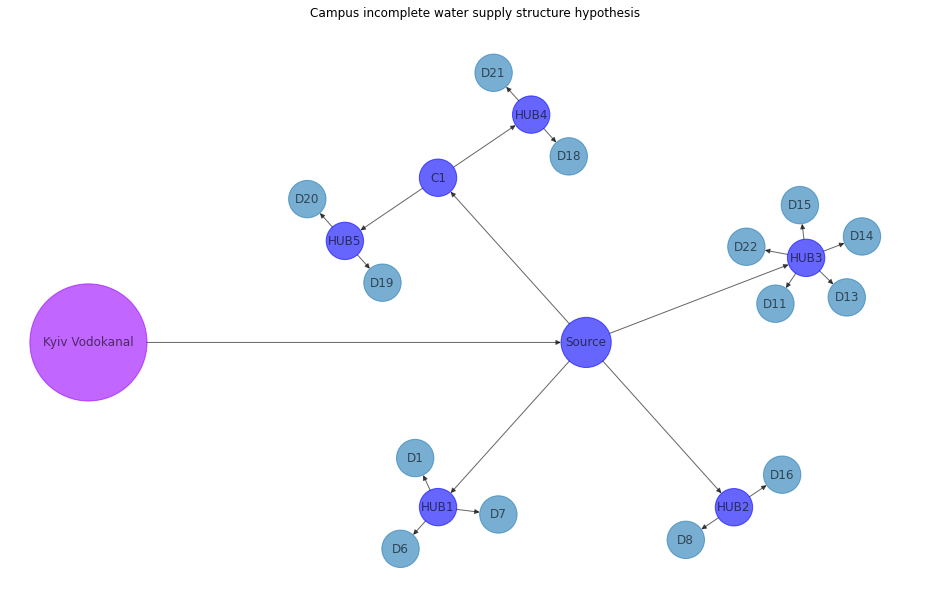

In [28]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


# Init directed graph
G = nx.DiGraph()
# Add nodes with different color, mark non-dormitories
G.add_node('Kyiv Vodokanal', color='#9900ff')
G.add_nodes_from(['Source', 'HUB1', 'HUB2', 'HUB3', 'HUB4', 'HUB5', 'C1',], color='#0000ff')
# Add connections between the nodes
G.add_edges_from([('Kyiv Vodokanal', 'Source'),
                  ('HUB1', 'D1'), ('HUB1', 'D6'), ('HUB1', 'D7'),
                  ('HUB2', 'D8'), ('HUB2', 'D16'),
                  ('HUB3', 'D11'), ('HUB3', 'D13'), ('HUB3', 'D14'), ('HUB3', 'D15'), ('HUB3', 'D22'), 
                  ('HUB4', 'D18'), ('HUB4', 'D21'),
                  ('HUB5', 'D20'), ('HUB5', 'D19'), 
                  ('Source', 'HUB1'), ('Source', 'HUB2'), ('Source', 'HUB3'), ('Source', 'C1'),
                  ('C1', 'HUB4'), ('C1', 'HUB5'),
                  ], resilience=1, days_to_fix=0)
# Set parameter if node has a water
G.add_nodes_from(G.nodes, has_water=True)
# Paint all the other nodes in different color
colors = [ node[1]['color'] if node[1].get('color') else "#1f78b4" 
          for node in G.nodes(data=True)]

# Make the graph
positions = nx.kamada_kawai_layout(G)
label_list = list(positions.keys())
plt.figure(figsize=(13, 8))

nx.draw(G,
        with_labels=True,
        node_color=colors,
        alpha=0.6, 
        arrows=True,
        node_size=[len(i)**2 * 70 if len(i) > 4 else 1400 for i in label_list],
        pos=nx.nx_agraph.graphviz_layout(G, prog="circo"),
)

plt.title("Campus incomplete water supply structure hypothesis")
plt.show()

# Light freeze graph
light_freeze = G.copy()

# Fault modelling

To simplify modelling pipes (graph edges) only will have some durability value which can decrease in time, for the same purposes suppose that dormitories consume 100% of the capacity of available water supply and water pipes have the same reliability whether they pass through themselves 1 conventional unit of water or 1000.

The water flow process and pipe reliability decrease will be considered as a discrete process with the unit of one day.

The less resilient edge was when the fault arose the more time will be spent on fixing the breakage.

In [54]:
YEAR = 365
YEARS = lambda y: y*YEAR

def set_water_status(G, start_node='Kyiv Vodokanal', status=True):
    """
    Set water status to all subgraph
    """
    for suc in G.successors(start_node):
        G.nodes[suc]["has_water"] = status
        set_water_status(G, suc, status)

def hit_pipes(G, start_node='Kyiv Vodokanal', decrease_rate=0.01, max_linear_fix_days=31):
    """
    Decrease strength of pipes
    from random go brrrrrr
    """

    # Decrease strength of pipes randomly with step of decrease_rate
    for suc in G.successors(start_node):
        if G.nodes[suc]["has_water"]:
            G[start_node][suc]["resilience"] -= np.random.choice([0, 1])*decrease_rate
            G.nodes[suc]["has_water"] = np.random.choice(
                [True, False],
                p=[G[start_node][suc]["resilience"], 1 - G[start_node][suc]["resilience"]]
            )
            if not G.nodes[suc]["has_water"]:
                G[start_node][suc]["days_to_fix"] = 1+ np.ceil((1 - G[start_node][suc]["resilience"]) * max_linear_fix_days)
                set_water_status(G, suc, False)
    # If it has less strength, it is more likely not to have water
    for suc in G.successors(start_node):
        hit_pipes(G, suc, decrease_rate)

def fix_pipes(G, start_node='Kyiv Vodokanal',):
    """
    Fixing brygada
    Increases the strength of only broken pipes
    Set water availability after the fix
    """
    for suc in G.successors(start_node):
        # if not G.nodes[suc]["has_water"]:
        # print("G[start_node][suc]['days_to_fix']", G[start_node][suc]["days_to_fix"], start_node, suc)
        is_fixed_recently = G[start_node][suc]["days_to_fix"]

        if G[start_node][suc]["days_to_fix"] > 0:
            G[start_node][suc]["days_to_fix"] -= 1
        is_fixed_recently = is_fixed_recently != G[start_node][suc]["days_to_fix"]
        if G[start_node][suc]["days_to_fix"] - 1 < 0.01:
            if is_fixed_recently:
                G[start_node][suc]["resilience"] = 1.0
            G.nodes[suc]["has_water"] = True
            fix_pipes(G, suc)

def display_info(G):
    """
    Current implementation of displaying th information graph contains
    """
    print("All nodes", list(G.edges(data=True)))
    print("Dorms without water", list(filter(lambda i: not i[1], nx.get_node_attributes(G, 'has_water').items())))
    print("Problem pipes", list(filter(lambda i: i[1] > 0, nx.get_edge_attributes(G, 'days_to_fix').items())))


In [56]:
G = light_freeze.copy()

print(f"Day 0")
display_info(G)

for i in range(YEARS(1)):
    print(f"Day {i+1}")
    hit_pipes(G, decrease_rate=0.001, max_linear_fix_days=30)
    fix_pipes(G)
    display_info(G)
# list(G.successors('Source'))

Day 0
All nodes [('Kyiv Vodokanal', 'Source', {'resilience': 1, 'days_to_fix': 0}), ('Source', 'HUB1', {'resilience': 1, 'days_to_fix': 0}), ('Source', 'HUB2', {'resilience': 1, 'days_to_fix': 0}), ('Source', 'HUB3', {'resilience': 1, 'days_to_fix': 0}), ('Source', 'C1', {'resilience': 1, 'days_to_fix': 0}), ('HUB1', 'D1', {'resilience': 1, 'days_to_fix': 0}), ('HUB1', 'D6', {'resilience': 1, 'days_to_fix': 0}), ('HUB1', 'D7', {'resilience': 1, 'days_to_fix': 0}), ('HUB2', 'D8', {'resilience': 1, 'days_to_fix': 0}), ('HUB2', 'D16', {'resilience': 1, 'days_to_fix': 0}), ('HUB3', 'D11', {'resilience': 1, 'days_to_fix': 0}), ('HUB3', 'D13', {'resilience': 1, 'days_to_fix': 0}), ('HUB3', 'D14', {'resilience': 1, 'days_to_fix': 0}), ('HUB3', 'D15', {'resilience': 1, 'days_to_fix': 0}), ('HUB3', 'D22', {'resilience': 1, 'days_to_fix': 0}), ('HUB4', 'D18', {'resilience': 1, 'days_to_fix': 0}), ('HUB4', 'D21', {'resilience': 1, 'days_to_fix': 0}), ('HUB5', 'D20', {'resilience': 1, 'days_to_fix

# Conclusions

As the coefficients of resilience were randomly decreased the slope of the fault probability may not be linear even though random generator based on uniform distribution. This can be explained by that the stochastic process has uniform distribution only on average of the ensemble but that is not guaranteed on a separate single process.

The resilience on this moddeling is chosen to have the most impact on time. What is untrivial is that the speed of the fixing brigade heavily impact not only on number of days that pipe would be fixed but on the pipe fault situation in general.

In more complex and closer to real-life modelling that factor could not be linear but the general conclusions of the probability of a fault correlate with the pipes resilience would be in the top cause of a fault.